In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

image = shepp_logan_phantom()
image = rescale(image, scale=.4, mode='reflect', channel_axis=None)
print(image.shape)

(160, 160)


(160, 180)


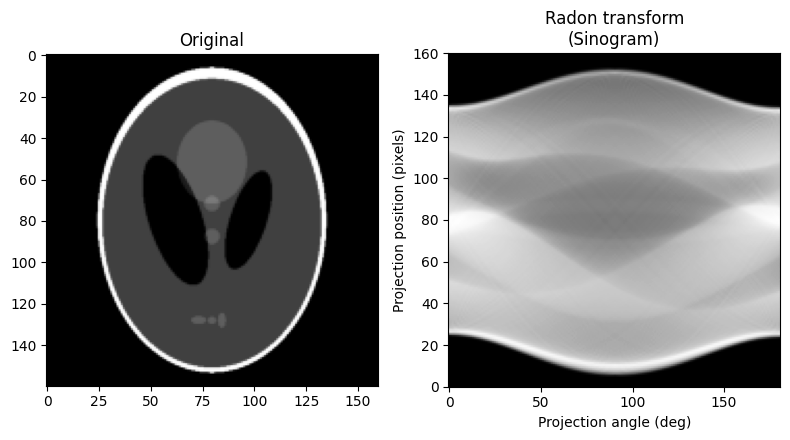

In [14]:
from radon import radon

angles = np.arange(0, 180, 1)
sino = radon(image, angles=angles, method='bilinear')
print(sino.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sino.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sino,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sino.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

FBP rms using ramp-filter gives reconstruction error: 0.028220
FBP rms using shepp-logan-filter gives reconstruction error: 0.032775
FBP rms using cosine-filter gives reconstruction error: 0.041970
FBP rms using hamming-filter gives reconstruction error: 0.049620
FBP rms using hann-filter gives reconstruction error: 0.051567


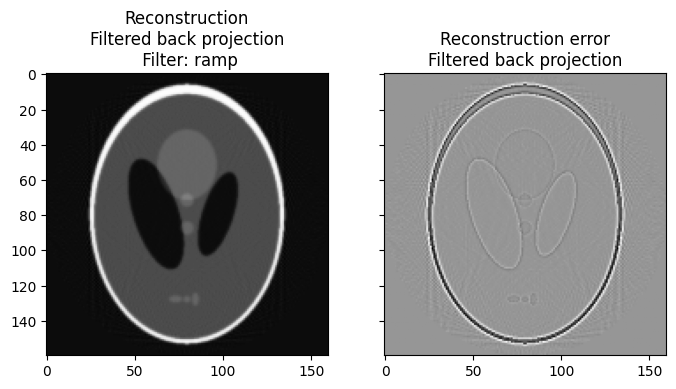

In [15]:
from skimage.transform import iradon

curr = 1.
for filter in ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']:
    reconstruction_fbp = iradon(sino, theta=angles, filter_name=filter)
    error = reconstruction_fbp - image
    errval = np.sqrt(np.mean(error ** 2))
    if errval < curr:
        best_filter = filter
        curr = errval
    print(f'FBP rms using {filter}-filter gives reconstruction error: {errval:.6f}')

reconstruction_fbp = iradon(sino, theta=angles, filter_name=best_filter)

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title(f"Reconstruction\nFiltered back projection\n Filter: {best_filter}")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

# Control Comparison to SkImage

(160, 160)


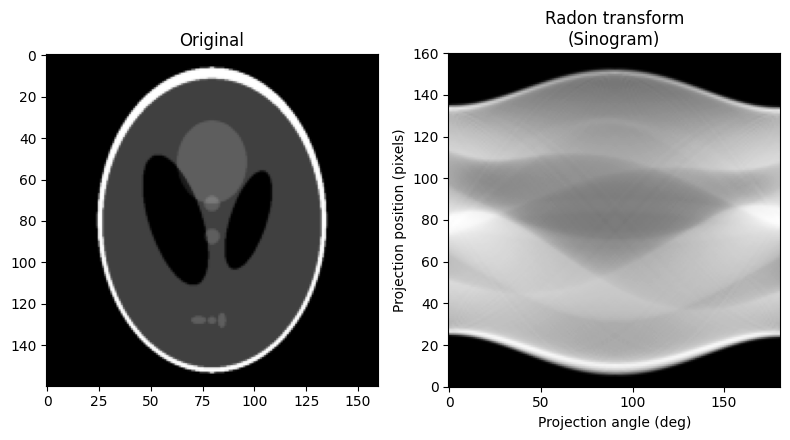

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

FBP rms reconstruction error: 0.0283


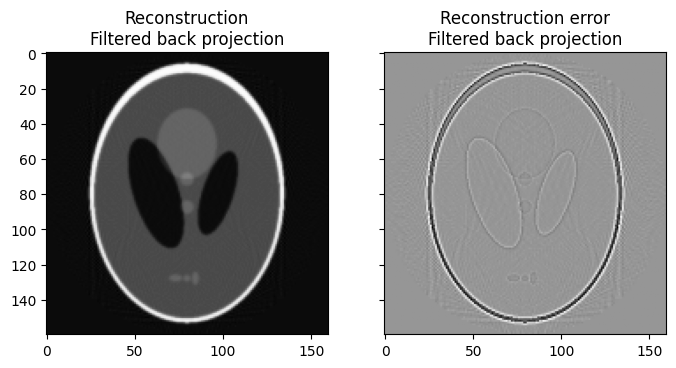

In [17]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

In [20]:
from skimage.transform import radon, rotate
import numpy as np


def get_image_center(img):

    center = (img.shape[0] * 0.5, img.shape[1] * 0.5)

    return center

def rotate_image(img, deg):

    rotated_img = rotate(img, 
                         deg, 
                         center=get_image_center(img), 
                         preserve_range=True)

    return rotated_img

theta_test = np.linspace(0, 360, 100)

sinogram = radon(image, theta=theta_test, circle=True)

def perform_radon(img, angle_vector):

    radon_result_list = []
    x_projection_matrix = np.ones(img.shape[0])

    for angle in angle_vector:
        rotated_img = rotate_image(img,  - angle)
        radon_transform = np.dot(x_projection_matrix, rotated_img)
        radon_result_list.append(radon_transform)

    arr = np.vstack(radon_result_list).T

    return arr

manual_radon = perform_radon(image, theta_test)
manual_radon.shape

np.allclose(manual_radon, sinogram)

True

In [ ]:
def radonmatrix(image, drho, dtheta):
    """
    % radonmatrix - Discrete Radon Trasnform matrix
    %
    % SYNOPSIS
    %   [ R rho theta ] = radonmatrix( drho, dtheta, M, N )
    %
    % DESCRIPTION
    %   Returns a matrix representation of a Discrete Radon
    %   Transform (DRT).
    %
    % INPUT
    %   drho     Radial spacing the the DRT.
    %   dtheta   Angular spacing of the DRT (rad).
    %   M        Number of rows in the image.
    %   N        Number of columns in the image.
    %
    % OUTPUT
    %   R        LP x MN DRT matrix. The values of the L and
    %            P will depend on the radial and angular spacings.
    %   rho      Vector of radial sample locations.
    %   theta    Vector of angular sample locations (rad).
    %
    
    % For each angle, we define a set of rays parameterized
    % by rho. We then find the pixels on the MxN grid that
    % are closest to each line. The elements in R corresponding
    % to those pixels are given the value of 1.
    
    % The maximum extent of the region of support. It's for
    % rho = 0 and theta = pi/4, the line that runs caddy-corner."""
    M, N = np.shape(image)
    
    W = np.sqrt( M^2 + N^2 )
    
    rho = np.arange(-W/2, W/2, drho)
    theta = np.arange(0,180, dtheta)
    
    S = len(rho)
    P = len(theta)
    
    R = np.zeros((S*P,M*N))
    
    # Define a meshgrid w/ (0,0) in the middle that
    # we can use a standard coordinate system.
    xv, yv = np.meshgrid(np.arange(M), np.arange(N))
    
    % We loop over each angle and define all of the lines.
    % We then just figure out which indices each line goes
    % through and put a 1 there.
    for ii = 1 : P
    
      phi = theta(ii) * pi/180;
    
      % The equaiton is rho = m * sin(phi) + n * cos(phi).
      % We either define a vector for m and solve for n
      % or vice versa. We chose which one based on angle
      % so that we never g4et close to dividing by zero.
      if( phi >= pi/4 && phi <= 3*pi/4 )
    
        t =  -W : min( 1/sqrt(2), 1/abs(cot(phi)) ) : +W;
        T = length( t );
    
        rhom = repmat( rho(:), 1, T );
        tn = repmat( t(:)', L, 1 );
        mline = ( rhom - tn * cos(phi) ) ./ sin(phi);
    
        for jj = 1 : L
          p = round( tn(jj,:) - min( nimg ) ) + 1;
          q = round( mline(jj,:) - min( mimg ) ) + 1;  
          inds = p >= 1 & p <= N & q >= 1 & q <= M;
          R( (ii-1)*L + jj, unique( sub2ind( [ M N ], q(inds), p(inds) ) ) ) = 1;
        end
    
      else
    
        t =  -W : min( 1/sqrt(2), 1/abs(tan(phi)) ) : +W;
        T = length( t );
    
        rhon = repmat( rho(:)', T, 1 );    
        tm = repmat( t(:), 1, L );
        nline = ( rhon - tm * sin(phi) ) ./ cos(phi);
    
        for jj = 1 : L
          p = round( nline(:,jj) - min( nimg ) ) + 1;
          q = round( tm(:,jj) - min( mimg ) ) + 1;  
          inds = p >= 1 & p <= N & q >= 1 & q <= M;
          R( (ii-1)*L + jj, unique( sub2ind( [ M N ], q(inds), p(inds) ) ) ) = 1;
        end
    
      end
    
    end
    
    R = double( sparse( R ) );
    
    return;